In [1]:
pip install -r "/content/requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for mixpeek: filename=mixpeek-1.7-py3-none-any.whl size=2996 sha256=a28377dd05fa5d407bfa8bf86bf9043aa0bb571a2460238880512cc2bdc80465
  Stored in directory: /root/.cache/pip/wheels/87/58/46/2308be9b60f662a16b85069abd3e5bac1ab9b01e49ce4ea669
  Created wheel for rdp: filename=rdp-0.8-py3-none-any.whl size=4586 sha256=49546b7d9950739d79b7f2300c5f87ff3cc8cb3e4c0fdf1856933c2c72d7c015
  Stored in directory: /root/.cache/pip/wheels/5d/12/ec/0fc50553af000b9c3d2c74b9f77a01ae4bfe856e9917ac239c
Successfully built mixpeek rdp


In [2]:
import ezdxf
import sys
import numpy as np
from rdp import rdp
import pprint as pp
from collections import defaultdict
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

def print_entity(e):
    print("LINE on layer: %s\n" % e.dxf.layer)
    print("start point: %s\n" % e.dxf.start)
    print("end point: %s\n" % e.dxf.end)

def print_entity2(e):
    print(e.dxf.layer, e.dxf.start, e.dxf.end )

def transform(vertices, new_center, axis1, axis2):
    mat = np.linalg.inv(np.array([axis1, axis2])) @ np.array([[1, 0], [0, 1]])
    transformed_vertices = (vertices - new_center) @ mat
    return transformed_vertices

def transform_single_axis(vertices, new_center, axis1, direct):
    if direct:
        axis2 = np.array([-axis1[1], axis1[0]])
    else:
        axis2 = np.array([axis1[1]], -axis1[0])
    return transform(vertices, new_center, axis1, axis2)

def plot(l, fig=True):
    if fig:
        plt.figure(figsize=(10,10))
    plt.plot(list(l[:, 0]) + [l[0, 0]], list(l[:, 1]) + [l[0, 1]])
    for i, vertice in enumerate(l):
        plt.annotate(str(i), vertice)
    plt.axis('equal')

def perp(a) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

def seg_intersect(a1, a2, b1, b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

def envelope(polygon, dist):
    shifted_segments = []
    for i in range(len(polygon)):
        a, b = polygon[i], polygon[(i+1)%len(polygon)]
        dx = b[0] - a[0]
        dy = b[1] - a[1]
        normal = np.array([dy, -dx])
        normal /= np.linalg.norm(normal)
        shifted_segments.append((a + dist*normal, b + dist*normal))
    new_polygon = []
    for i in range(len(shifted_segments)):
        seg1 = shifted_segments[(i-1)%len(shifted_segments)]
        seg2 = shifted_segments[i]
        new_polygon.append(seg_intersect(seg1[0], seg1[1], seg2[0], seg2[1]))
    return np.array(new_polygon)

def get_circle(x, y, z):
    x, y, z = x[0]+x[1]*1j, y[0]+y[1]*1j, z[0]+z[1]*1j
    w = (z-x) / (y-x)
    c = (x-y)*(w-abs(w)**2)/2j/w.imag-x
    return -c.real, -c.imag, abs(c+x)

def array2dict(lst):
    res_dict = {}
    for i in range(0, len(lst), 1):
        res_dict[i] = lst[i]
    return res_dict


In [10]:
doc = ezdxf.readfile("mgf.dxf")
msp = doc.modelspace()
#
# LAYERS
#
for layer in doc.layers:
    print(layer.dxf.name)

0
05-Bâti_construction
05-Bâti_surplomb
06-Mur
06-Portail
07-Clôture
08-Escalier_marche
08-Escalier_flèche
09-Chaussée-avec-bordure
09-Bateau
09-Voirie_texte
11-Arbre
12-Mobilier-urbain
24-Réseau_Eau
20-Réseau_Assainissement
29-Réseau_Divers
99-Titre
99-Nord
99-Logo
14-Nature_sol
05-Bâti_contour-hachures
11-Arbustes
99-Texte
05-Bâti_contour
09-Allée-avec-bordurette
25-Réseau_Eclairage-privé
05-Bâti_hachures
09-Chaussée-sans-bordure
99-Légende
10-Signalisation_horizontale
91-Intérieur_cotation
91-Intérieur_sanitaires
99-Fenêtre-présentation
--FLF-Str-Esc-Flèche
--FLF-0-poubelle
--FLF-Cadre-100
--FLF-Cadre
FLF-BATI
Defpoints


In [11]:
#
# LAYERS with ENTITIES by type
#
group = msp.groupby(dxfattrib="layer")
a = defaultdict(lambda: defaultdict(lambda: 0))
for layer, entities in group.items():
    for entity in entities:
        a[layer][entity.dxftype()] += 1
a = {k: dict(a[k]) for k in a}
pp.pprint(a)


{'--FLF-Str-Esc-Flèche': {'ARC': 1, 'LINE': 2, 'LWPOLYLINE': 5},
 '0': {'ACAD_PROXY_ENTITY': 20, 'INSERT': 3, 'LINE': 2},
 '05-Bâti_construction': {'CIRCLE': 1,
                          'INSERT': 1,
                          'LINE': 30,
                          'LWPOLYLINE': 8},
 '05-Bâti_contour': {'LWPOLYLINE': 3},
 '05-Bâti_contour-hachures': {'LWPOLYLINE': 2},
 '05-Bâti_hachures': {'HATCH': 3},
 '05-Bâti_surplomb': {'LINE': 5, 'LWPOLYLINE': 1},
 '06-Mur': {'ARC': 9, 'CIRCLE': 3, 'LINE': 72, 'LWPOLYLINE': 13},
 '06-Portail': {'INSERT': 3, 'LINE': 9, 'LWPOLYLINE': 3},
 '07-Clôture': {'INSERT': 4, 'LINE': 33, 'LWPOLYLINE': 3},
 '08-Escalier_flèche': {'ARC': 1, 'LWPOLYLINE': 1},
 '08-Escalier_marche': {'LINE': 11, 'LWPOLYLINE': 2},
 '09-Allée-avec-bordurette': {'LINE': 11, 'LWPOLYLINE': 2},
 '09-Bateau': {'LWPOLYLINE': 1},
 '09-Chaussée-avec-bordure': {'ARC': 8, 'LINE': 98, 'LWPOLYLINE': 44},
 '09-Chaussée-sans-bordure': {'LINE': 9},
 '09-Voirie_texte': {'TEXT': 14},
 '10-Signalisati

In [12]:
#
# LWPOLYLINES in LAYER
#
lines = []
all_vertices = []
layer='05-Bâti_contour'

for polyline in msp.query(f'LWPOLYLINE[layer=="{layer}"]'):
  line = []
  for vertice in polyline:
    line.append([vertice[0], vertice[1]])
    all_vertices.append([vertice[0], vertice[1]])
  line = np.array(line)
  lines.append(line)

# Nouvelle section

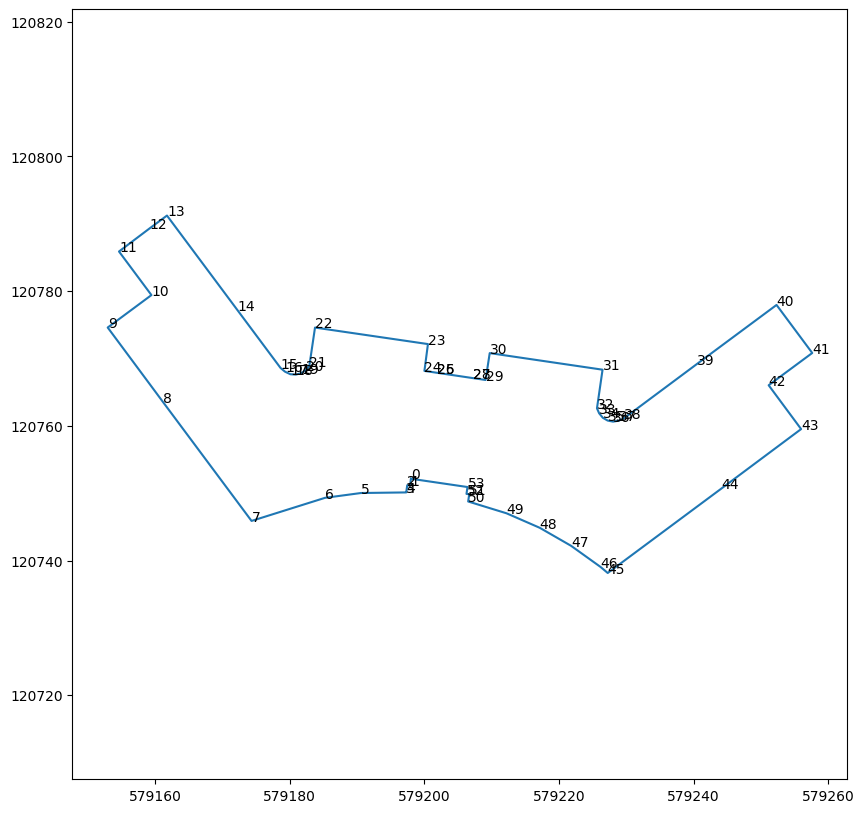

In [14]:


# DRAW 1st POLYLINE
plot(lines[0])

In [ ]:
# NORMALIZE POLYLINE + new center + new axis
line = lines[0]
#new_center = (line[22] + line[31])/2
new_center = (line[9] + line[7])/2
new_center = seg_intersect(line[7],line[9], line[13],line[11])

#axis1 = line[31] - line[22]
axis1 = line[7] - line[9]
axis1 /= np.linalg.norm(axis1)
new_line = transform_single_axis(line, new_center, axis1, True)
print(new_line)

[[52.929 22.734]
 [53.657 22.006]
 [53.368 21.716]
 [54.132 20.953]
 [54.128 20.948]
 [50.196 15.514]
 [47.582 10.801]
 [43.823  0.   ]
 [21.921 -0.012]
 [ 8.031  0.   ]
 [ 8.042  8.086]
 [-0.027  8.084]
 [-0.066 13.793]
 [-0.056 16.984]
 [17.405 17.001]
 [28.154 17.01 ]
 [28.997 17.209]
 [29.784 17.625]
 [30.31  18.237]
 [30.62  19.017]
 [30.65  19.827]
 [30.467 20.63 ]
 [26.409 24.697]
 [38.384 36.689]
 [41.27  33.891]
 [42.629 35.247]
 [42.629 35.247]
 [46.411 39.019]
 [46.411 39.019]
 [47.771 40.375]
 [44.934 43.249]
 [56.91  55.224]
 [61.017 51.135]
 [61.804 50.954]
 [62.656 50.995]
 [63.416 51.318]
 [64.029 51.871]
 [64.428 52.655]
 [64.602 53.475]
 [64.594 66.936]
 [64.614 81.693]
 [73.501 81.689]
 [73.481 73.638]
 [81.581 73.619]
 [81.603 58.837]
 [81.591 37.824]
 [80.236 37.505]
 [75.108 35.868]
 [70.189 33.734]
 [65.511 31.057]
 [60.704 27.533]
 [59.94  28.296]
 [59.65  28.006]
 [58.922 28.734]]


In [ ]:
new_line = np.array([        [   0 ,   0 ],
        [   0 , 110 ],
        [38.8 , 110 ],
        [38.8 ,  65 ],
        [  84 ,  65 ],
        [  84 , 150 ],
        [ 124 , 150 ],
        [ 124 ,  65 ],
        [ 167 ,  65 ],
        [ 167 , 115 ],
        [ 207 , 115 ],
        [ 207 ,  25 ],
        [ 177 ,  25 ],
        [ 177 ,   0 ],
        [ 142 ,   0 ],
        [ 142 ,  25 ],
        [ 112 ,  25 ],
        [ 112 ,   3 ],
        [  97 ,   3 ],
        [  97 ,  25 ],
        [  62 ,  25 ],
        [  62 ,   0 ]])

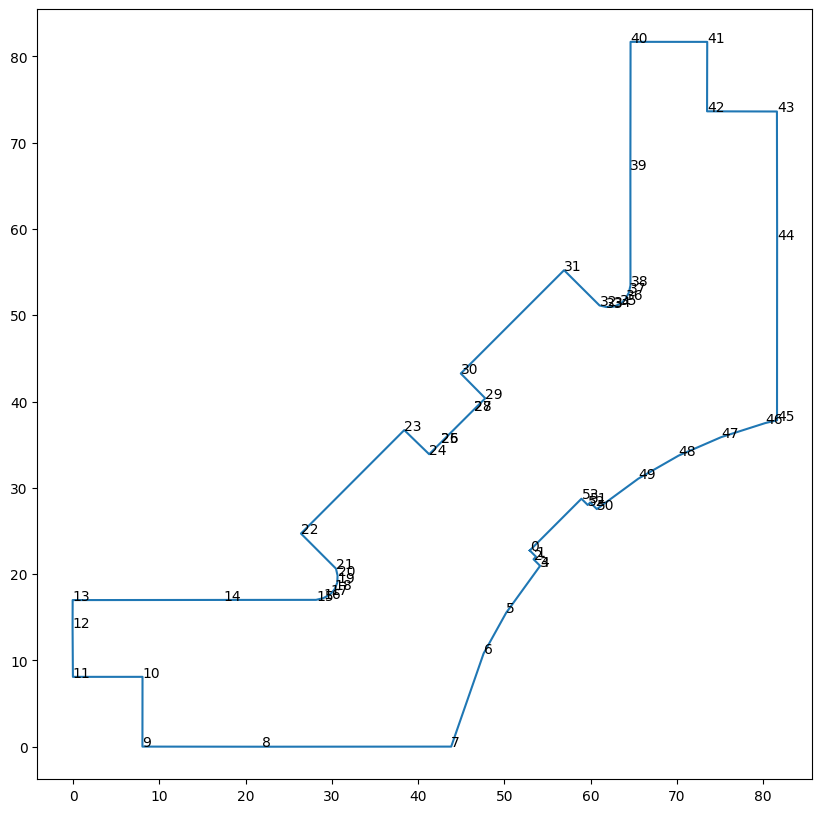

In [ ]:
plot(new_line)

54 37
{0: array([52.929, 22.734]),
 1: array([53.657, 22.006]),
 2: array([53.368, 21.716]),
 3: array([54.132, 20.953]),
 4: array([50.196, 15.514]),
 5: array([47.582, 10.801]),
 6: array([43.823,  0.   ]),
 7: array([8.031, 0.   ]),
 8: array([8.042, 8.086]),
 9: array([-0.027,  8.084]),
 10: array([-0.056, 16.984]),
 11: array([28.154, 17.01 ]),
 12: array([29.784, 17.625]),
 13: array([30.62 , 19.017]),
 14: array([30.467, 20.63 ]),
 15: array([26.409, 24.697]),
 16: array([38.384, 36.689]),
 17: array([41.27 , 33.891]),
 18: array([47.771, 40.375]),
 19: array([44.934, 43.249]),
 20: array([56.91 , 55.224]),
 21: array([61.017, 51.135]),
 22: array([62.656, 50.995]),
 23: array([64.029, 51.871]),
 24: array([64.602, 53.475]),
 25: array([64.614, 81.693]),
 26: array([73.501, 81.689]),
 27: array([73.481, 73.638]),
 28: array([81.581, 73.619]),
 29: array([81.591, 37.824]),
 30: array([75.108, 35.868]),
 31: array([70.189, 33.734]),
 32: array([65.511, 31.057]),
 33: array([60.704

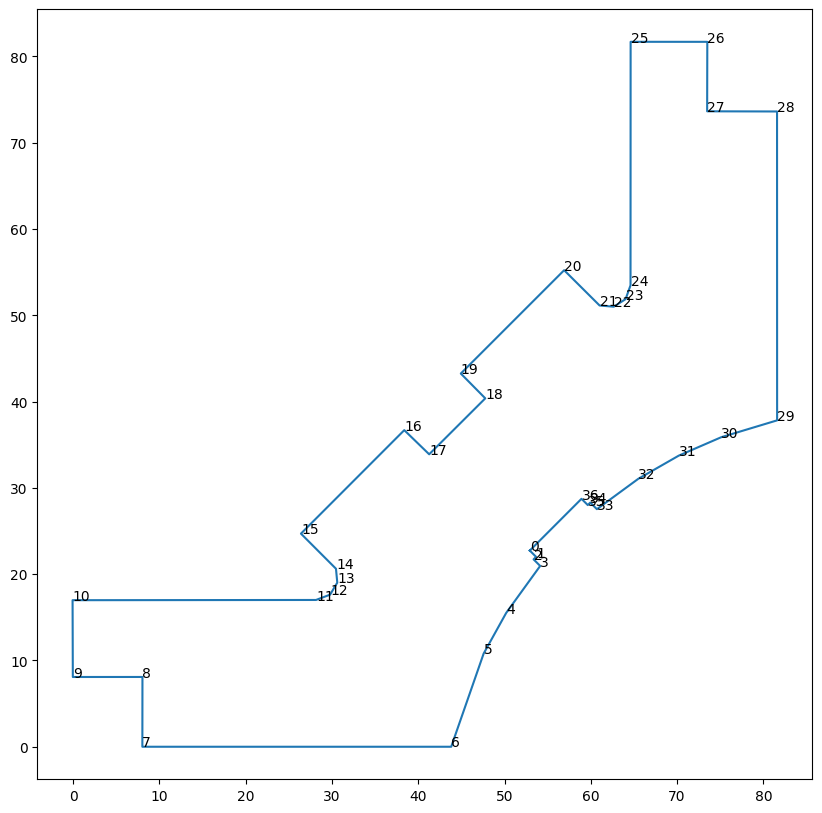

In [ ]:
#
# Reduce Points
#
simple_line = rdp(new_line, epsilon=0.2)
print(len(new_line), len(simple_line))
plot(simple_line)

# convert Array into Dict
dict_line = array2dict(simple_line)
pp.pprint(dict_line)

[ 1.03   0.41   1.08   6.714  5.389 11.437 35.791  8.086  8.069  8.899
 28.21   1.741  1.624  1.62   5.745 16.948  4.02   9.181  4.038 16.936
  5.796  1.644  1.629  1.703 28.218  8.887  8.051  8.1   35.795  6.771
  5.362  5.389  5.961  1.08   0.41   1.03   8.48 ]


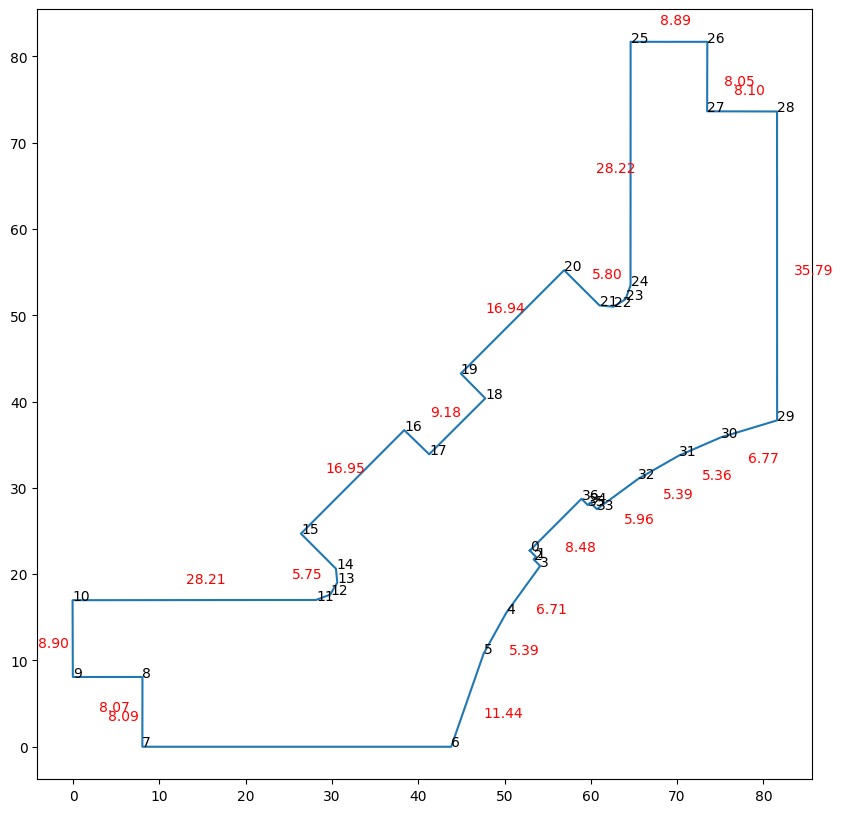

In [ ]:
int_line = envelope(simple_line, 2.)
plt.figure(figsize=(10,10))
plot(simple_line, False)
#plot(int_line, False)
lengths = []
for i in range(len(simple_line)):
    a, b = simple_line[i], simple_line[(i+1)%len(simple_line)]
    dx, dy = b[0]-a[0], b[1]-a[1]
    normal = np.array([dy, -dx])
    normal /= np.linalg.norm(normal)
    length = np.linalg.norm(a - b)
    lengths.append(length)
    if length > 5:
        plt.annotate("%.2f" % length, (a+b)/2 - 3.*normal - 1., color='red')
print(np.array(lengths))


In [ ]:
#centerx, centery, radius = get_circle(new_line[7], new_line[50], new_line[45])
centerx, centery, radius = get_circle(new_line[16], new_line[18], new_line[21])
print(centerx, centery, radius)

28.201591063209122 19.577485930188082 2.4983033721166876
